In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [3]:
class DNNClassifier(object):
    '''
    Parameters: layer_dims -- List Dimensions of layers including input and output layer
                hidden_layers -- List of hidden layers
                                 'relu','sigmoid','tanh','softplus','arctan','elu','identity','softmax'
                                 Note: 1. last layer must be softmax 
                                       2. For relu and elu need to mention alpha value as below
                                        ['tanh',('relu',alpha1),('elu',alpha2),('relu',alpha3),'softmax']
                                        need to give a tuple for relu and elu if you want to mention alpha
                                        if not default alpha is 0
                init_type -- init_type -- he_normal  --> N(0,sqrt(2/fanin))
                             he_uniform --> Uniform(-sqrt(6/fanin),sqrt(6/fanin))
                             xavier_normal --> N(0,2/(fanin+fanout))
                             xavier_uniform --> Uniform(-sqrt(6/fanin+fanout),sqrt(6/fanin+fanout))
                                 
                learning_rate -- Learning rate
                optimization_method -- optimization method 'SGD','SGDM','RMSP','ADAM'
                batch_size -- Batch size to update weights 
                max_epoch -- Max epoch number
                             Note : Max_iter  = max_epoch * (size of traing / batch size)
                tolarance -- if abs(previous cost  - current cost ) < tol training will be stopped
                             if None -- No check will be performed
                keep_proba -- probability for dropout
                              if 1 then there is no dropout
                penality -- regularization penality
                            values taken 'l1','l2',None(default)
                lamda -- l1 or l2 regularization value
                beta1 -- SGDM and adam optimization param
                beta2 -- RMSP and adam optimization value
                seed -- Random seed to generate randomness
                verbose -- takes 0  or 1 
    '''
    
    def __init__(self,layer_dims,hidden_layers,init_type='he_normal',learning_rate=0.1,
                 optimization_method = 'SGD',batch_size=64,max_epoch=100,tolarance = 0.00001,
                 keep_proba=1,penality=None,lamda=0,beta1=0.9,
                 beta2=0.999,seed=None,verbose=0):
        self.layer_dims = layer_dims
        self.hidden_layers = hidden_layers
        self.init_type = init_type
        self.learning_rate = learning_rate
        self.optimization_method = optimization_method
        self.batch_size = batch_size
        self.keep_proba = keep_proba
        self.penality = penality
        self.lamda = lamda
        self.beta1 = beta1
        self.beta2 = beta2
        self.seed = seed
        self.max_epoch = max_epoch
        self.tol = tolarance
        self.verbose = verbose
    @staticmethod
    def weights_init(layer_dims,init_type='he_normal',seed=None):
        
        """
        Arguments:
            layer_dims -- python array (list) containing the dimensions of each layer in our network
            layer_dims lis is like  [ no of input features,# of neurons in hidden layer-1,..,
                                     # of neurons in hidden layer-n shape,output]
            init_type -- he_normal  --> N(0,sqrt(2/fanin))
                         he_uniform --> Uniform(-sqrt(6/fanin),sqrt(6/fanin))
                         xavier_normal --> N(0,2/(fanin+fanout))
                         xavier_uniform --> Uniform(-sqrt(6/fanin+fanout),sqrt(6/fanin+fanout))
                         seed -- random seed to generate weights
        Returns:
            parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
        """
        np.random.seed(seed)
        parameters = {}
        opt_parameters = {}
        L = len(layer_dims)            # number of layers in the network
        if  init_type == 'he_normal':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], 1))  
            
        elif init_type == 'he_uniform':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], 1))
            
        elif init_type == 'xavier_normal':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),
                                                                   (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),
                                                                      (layer_dims[l], 1)) 
            
        elif init_type == 'xavier_uniform':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], 1))
        
        return parameters
    
    @staticmethod
    def sigmoid(X,derivative=False):
        '''Compute Sigmaoid and its derivative'''
        if derivative == False:
            out = 1 / (1 + np.exp(-np.array(X)))
        elif derivative == True:
            s = 1 / (1 + np.exp(-np.array(X)))
            out = s*(1-s)
        return out
    @staticmethod
    def ReLU(X,alpha=0,derivative=False):
        '''Compute ReLU function and derivative'''
        X = np.array(X,dtype=np.float64)
        if derivative == False:
            return np.where(X<0,alpha*X,X)
        elif derivative == True:
            X_relu = np.ones_like(X,dtype=np.float64)
            X_relu[X < 0] = alpha
            return X_relu
    @staticmethod
    def Tanh(X,derivative=False):
        '''Compute tanh values and derivative of tanh'''
        X = np.array(X)
        if derivative == False:
            return np.tanh(X)
        if derivative == True:
            return 1 - (np.tanh(X))**2
    @staticmethod
    def softplus(X,derivative=False):
        '''Compute tanh values and derivative of tanh'''
        X = np.array(X)
        if derivative == False:
            return np.log(1+np.exp(X))
        if derivative == True:
            return 1 / (1 + np.exp(-np.array(X)))
    @staticmethod
    def arctan(X,derivative=False):
        '''Compute tan^-1(X) and derivative'''
        if derivative == False:
            return  np.arctan(X)
        if derivative == True:
            return 1/ (1 + np.square(X))
    @staticmethod
    def identity(X,derivative=False):
        '''identity function and derivative f(x) = x'''
        X = np.array(X)
        if derivative ==  False:
            return X
        if derivative == True:
            return np.ones_like(X)
    @staticmethod
    def elu(X,alpha=0,derivative=False):
        '''Exponential Linear Unit'''
        X = np.array(X,dtype=np.float64)
        if derivative == False:
            return np.where(X<0,alpha*(np.exp(X)-1),X)
        elif derivative == True:
            return np.where(X<0,alpha*(np.exp(X)),1)
    @staticmethod
    def softmax(X):
        """Compute softmax values for each sets of scores in x."""
        return np.exp(X) / np.sum(np.exp(X),axis=0)
    @staticmethod
    def forward_propagation(X, hidden_layers,parameters,keep_prob=1,seed=None):
    
        """"
        Arguments:
            X -- data, numpy array of shape (input size, number of examples)
            hidden_layers -- List of hideden layers
            weights -- Output of weights_init dict (parameters)
            keep_prob -- probability of keeping a neuron active during drop-out, scalar
        Returns:
            AL -- last post-activation value
            caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
        """
        if seed != None:
            np.random.seed(seed)
        caches = []
        A = X
        L = len(hidden_layers)
        for l,active_function in enumerate(hidden_layers,start=1):
            A_prev = A 
        
            Z = np.dot(parameters['W' + str(l)],A_prev)+parameters['b' + str(l)]
            
            if type(active_function) is tuple:
                
                if  active_function[0] == "relu":
                    A = DNNClassifier.ReLU(Z,active_function[1])
                elif active_function[0] == 'elu':
                    A = DNNClassifier.elu(Z,active_function[1])
            else:
                if active_function == "sigmoid":
                    A = DNNClassifier.sigmoid(Z)
                elif active_function == "identity":
                    A = DNNClassifier.identity(Z)
                elif active_function == "arctan":
                    A = DNNClassifier.arctan(Z)
                elif active_function == "softplus":
                    A = DNNClassifier.softplus(Z)
                elif active_function == "tanh":
                    A = DNNClassifier.Tanh(Z)
                elif active_function == "softmax":
                    A = DNNClassifier.softmax(Z)
                elif  active_function == "relu":
                    A = DNNClassifier.ReLU(Z)
                elif active_function == 'elu':
                    A = DNNClassifier.elu(Z)
            
            if keep_prob != 1 and l != L and l != 1:
                D = np.random.rand(A.shape[0],A.shape[1])
                D = (D<keep_prob)
                A = np.multiply(A,D)
                A = A / keep_prob
                cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)],D), Z)
                caches.append(cache)
            else:
                cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)]), Z)
                #print(A.shape)
                caches.append(cache)      
        return A, caches
    @staticmethod
    def compute_cost(A, Y, parameters, lamda=0,penality=None):
        """
        Implement the cost function with L2 regularization. See formula (2) above.
    
        Arguments:
            A -- post-activation, output of forward propagation
            Y -- "true" labels vector, of shape (output size, number of examples)
            parameters -- python dictionary containing parameters of the model
    
        Returns:
            cost - value of the regularized loss function 
        """
        m = Y.shape[1]
    
        cost = np.squeeze(-np.sum(np.multiply(np.log(A),Y))/m)
    
        L = len(parameters)//2
    
        if penality == 'l2' and lamda != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.square(parameters['W' + str(l)]))
            cost = cost + sum_weights * (lamda/(2*m))
        elif penality == 'l1' and lamda != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.abs(parameters['W' + str(l)]))
            cost = cost + sum_weights * (lamda/(2*m))
        return cost
    @staticmethod
    def back_propagation(AL, Y, caches, hidden_layers, keep_prob=1, penality=None,lamda=0):
        """
        Implement the backward propagation
    
        Arguments:
            AL -- probability vector, output of the forward propagation (L_model_forward())
            Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
            caches -- list of caches containing:
            hidden_layers -- hidden layer names
            keep_prob -- probabaility for dropout
            penality -- regularization penality 'l1' or 'l2' or None
    
        Returns:
             grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
        """
        grads = {}
        L = len(caches) # the number of layers
    
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
    
        # Initializing the backpropagation
        dZL = AL - Y
    
        cache = caches[L-1]
        linear_cache, activation_cache = cache
        AL, W, b = linear_cache
        grads["dW" + str(L)] = np.dot(dZL,AL.T)/m
        grads["db" + str(L)] = np.sum(dZL,axis=1,keepdims=True)/m
        grads["dA" + str(L-1)] = np.dot(W.T,dZL)
    
    
        # Loop from l=L-2 to l=0
        v_dropout = 0
        for l in reversed(range(L-1)):
            cache = caches[l]
            active_function = hidden_layers[l]
        
            linear_cache, Z = cache
            try:
                A_prev, W, b = linear_cache
            except:
                A_prev, W, b, D = linear_cache
                v_dropout = 1
            
            m = A_prev.shape[1]
        
            if keep_prob != 1 and v_dropout == 1:
                dA_prev = np.multiply(grads["dA" + str(l + 1)],D)
                dA_prev = dA_prev/keep_prob
                v_dropout = 0
            else:
                dA_prev = grads["dA" + str(l + 1)]
                v_dropout = 0
            
            
            if type(active_function) is tuple:
                
                if  active_function[0] == "relu":
                    dZ = np.multiply(dA_prev,DNNClassifier.ReLU(Z,active_function[1],derivative=True))
                elif active_function[0] == 'elu':
                    dZ = np.multiply(dA_prev,DNNClassifier.elu(Z,active_function[1],derivative=True))
            else:
                if active_function == "sigmoid":
                    dZ = np.multiply(dA_prev,DNNClassifier.sigmoid(Z,derivative=True))
                elif active_function == "relu":
                    dZ = np.multiply(dA_prev,DNNClassifier.ReLU(Z,derivative=True))
                elif active_function == "tanh":
                    dZ = np.multiply(dA_prev,DNNClassifier.Tanh(Z,derivative=True))
                elif active_function == "identity":
                    dZ = np.multiply(dA_prev,DNNClassifier.identity(Z,derivative=True))
                elif active_function == "arctan":
                    dZ = np.multiply(dA_prev,DNNClassifier.arctan(Z,derivative=True))
                elif active_function == "softplus":
                    dZ = np.multiply(dA_prev,DNNClassifier.softplus(Z,derivative=True))
                elif active_function == 'elu':
                    dZ = np.multiply(dA_prev,DNNClassifier.elu(Z,derivative=True))
            
            grads["dA" + str(l)] = np.dot(W.T,dZ)
        
            if penality == 'l2':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lamda * W)/m)
            elif penality == 'l1':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lamda * np.sign(W+10**-8))/m)
            else:
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)
            
            grads["db" + str(l + 1)] = np.sum(dZ,axis=1,keepdims=True)/m   
        return grads
    
    @staticmethod
    def update_parameters(parameters, grads,learning_rate,iter_no,method = 'SGD',opt_parameters=None,beta1=0.9,beta2=0.999):
        """
        Update parameters using gradient descent
    
        Arguments:
        parameters -- python dictionary containing your parameters 
        grads -- python dictionary containing your gradients, output of L_model_backward
        method -- method for updation of weights
                  'SGD','SGDM','RMSP','ADAM'
        learning rate -- learning rate alpha value
        beta1 -- weighted avg parameter for SGDM and ADAM
        beta2 -- weighted avg parameter for RMSP and ADAM
    
        Returns:
        parameters -- python dictionary containing your updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...
                      opt_parameters
        """
    
        L = len(parameters) // 2 # number of layers in the neural network
        if method == 'SGD':
            for l in range(L):
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]
            opt_parameters = None
        elif method == 'SGDM':
            for l in range(L):
                opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
                opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*opt_parameters['vdw'+str(l+1)]
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*opt_parameters['vdb'+str(l+1)]
        elif method == 'RMSP':
            for l in range(L):
                opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + \
                                                     (1-beta2)*np.square(grads["db" + str(l + 1)])
                opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + \
                                                           (1-beta2)*np.square(grads["dW" + str(l + 1)])
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(grads["dW" + str(l + 1)]/(np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(grads["db" + str(l + 1)]/(np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        elif method == 'ADAM':
            for l in range(L):
                opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
                opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
                opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + \
                                                                  (1-beta2)*np.square(grads["db" + str(l + 1)])
                opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + \
                                                                   (1-beta2)*np.square(grads["dW" + str(l + 1)])
            
                learning_rate = learning_rate * np.sqrt((1-beta2**iter_no)/((1-beta1**iter_no)+10**-8))
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdw'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdb'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        
        return parameters,opt_parameters
    
    def fit(self,X,y):
        '''
        X -- data, numpy array of shape (input size, number of examples)
        y -- lables, numpy array of shape (no of classes,n)
        
        '''
        
        np.random.seed(self.seed)
        self.grads = {}
        self.costs = []
        M = X.shape[1]
        opt_parameters = {}
        
        if self.verbose == 1:
            print('Initilizing Weights...')
        self.parameters = self.weights_init(self.layer_dims,self.init_type,self.seed)
        self.iter_no = 0
        idx = np.arange(0,M)
        
        if self.optimization_method != 'SGD':
            for l in range(1, len(self.layer_dims)):
                opt_parameters['vdw' + str(l)] = np.zeros((self.layer_dims[l], self.layer_dims[l-1]))
                opt_parameters['vdb' + str(l)] = np.zeros((self.layer_dims[l], 1))
                opt_parameters['sdw' + str(l)] = np.zeros((self.layer_dims[l], self.layer_dims[l-1]))
                opt_parameters['sdb' + str(l)] = np.zeros((self.layer_dims[l], 1)) 
        
        if self.verbose == 1:
            print('Starting Training...')
            
        costs = []    
            
        for epoch_no in range(1,self.max_epoch+1):
            np.random.shuffle(idx)
            X = X[:,idx]
            y = y[:,idx]
            for i in range(0,M, self.batch_size):
                self.iter_no = self.iter_no + 1
                X_batch = X[:,i:i + self.batch_size]
                y_batch = y[:,i:i + self.batch_size]
                # Forward propagation:
                AL, cache = self.forward_propagation(X_batch,self.hidden_layers,self.parameters,self.keep_proba,self.seed)
                #cost
                cost = self.compute_cost(AL, y_batch, self.parameters,self.lamda,self.penality)
                self.costs.append(cost)
                
                if self.tol != None:
                    try:
                        if abs(cost - self.costs[-2]) < self.tol:
                            return self
                    except:
                        pass
                #back prop
                grads = self.back_propagation(AL, y_batch, cache,self.hidden_layers,self.keep_proba,self.penality,self.lamda)
                
                #update params
                self.parameters,opt_parameters = self.update_parameters(self.parameters,grads,self.learning_rate,
                                                                        self.iter_no-1,self.optimization_method,
                                                                        opt_parameters,self.beta1,self.beta2)
                
                if self.verbose == 1:
                    if self.iter_no % 100 == 0:
                        print("Cost after iteration {}: {}".format(self.iter_no, cost))
                costs.append(cost)
                
        return self, cost, costs
    def predict(self,X,proba=False):
        '''predicting values
           arguments: X - iput data
                      proba -- False then return value
                               True then return probabaility
        '''
        
        out, _ = self.forward_propagation(X,self.hidden_layers,self.parameters,self.keep_proba,self.seed)
        if proba == True:
            return out.T
        else:
            return np.argmax(out, axis=0)

In [136]:
#for trials

from sklearn.datasets import make_moons

In [137]:
x,y =make_moons(n_samples=1500, noise=.05)
X = x.T
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
y_next = np.where(y==0,1,0)
Y = Y.T
Y = list(Y)
Y.append(y_next)
Y = np.array(Y)

In [138]:
Y.shape

(2, 1500)

In [139]:
model_moon = DNNClassifier(layer_dims=[X.shape[0], 6, 4,3, 2],hidden_layers=[('relu',0),('relu',0.001),'sigmoid','softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=512,max_epoch=700,verbose=0,seed=25)
model_moon.fit(X,Y)

(<__main__.DNNClassifier at 0x204e8322488>,
 0.0001607567145967497,
 [0.8208017509112124,
  0.7966095926880271,
  0.8557776078589189,
  0.817668796991114,
  0.8245169422550189,
  0.7737983855369561,
  0.7993939822430576,
  0.7938893098632787,
  0.742413983463107,
  0.7808005666336777,
  0.7225925471863646,
  0.7415364166708246,
  0.6867956239190663,
  0.7230357274686618,
  0.7555687257358655,
  0.7149534004642053,
  0.7194292249737155,
  0.6827913553745584,
  0.7089627740426827,
  0.6936735292429071,
  0.6883279834608277,
  0.6815465925181955,
  0.6852210185473332,
  0.702868560203215,
  0.659280189565371,
  0.6876724436738724,
  0.6995228713795759,
  0.6866974813711682,
  0.6601059899067901,
  0.6754250566479348,
  0.6635792309823569,
  0.6715663980746506,
  0.6615464293197652,
  0.6742853375947047,
  0.6691195649541657,
  0.6250764099018635,
  0.6196614697698233,
  0.6590549430136055,
  0.6635761000433288,
  0.6446953723225977,
  0.6293624854662485,
  0.6366327364706115,
  0.61654541

In [140]:
model_moon.predict(X)

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

(1500,)


Text(0.5, 1.0, 'Decision Boundaries')

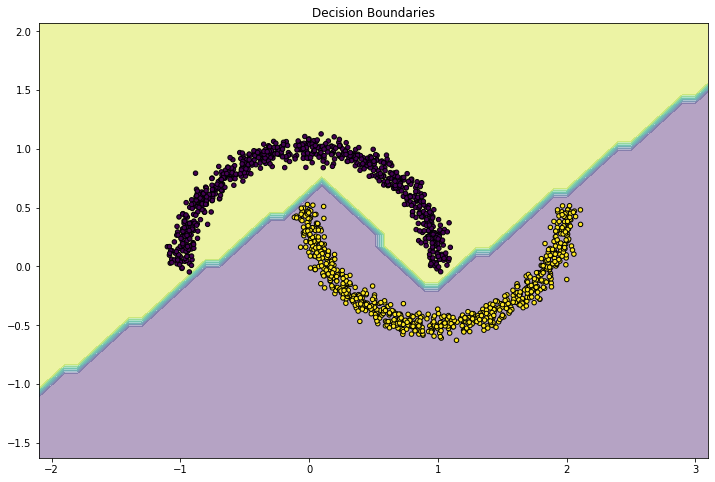

In [141]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model_moon.predict(np.c_[xx.ravel(), yy.ravel()].T) 
print(y.shape)
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries')

In [142]:
model_moon2 = DNNClassifier(layer_dims=[X.shape[0], 3, 2],hidden_layers=['sigmoid','softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=512,max_epoch=700,verbose=0,seed=25)
model_moon2.fit(X,Y)

(<__main__.DNNClassifier at 0x204e77b9ac8>,
 0.0008133481036966651,
 [1.1642823863196852,
  1.176750071933951,
  1.187228541393089,
  1.174381905671545,
  1.114439566566345,
  1.0544991791969365,
  1.0589479226947105,
  1.0956476647131497,
  0.9529983287129082,
  1.0156792621703057,
  0.9568611469344888,
  0.9153307196410897,
  0.9274430296167548,
  0.8950883768187285,
  0.8711241902336866,
  0.8484598085425785,
  0.8206173964234121,
  0.853308116772048,
  0.8058071594839266,
  0.7956488522444046,
  0.7654017045153914,
  0.7672898715786275,
  0.7197145820390187,
  0.7378549647353765,
  0.7104869900192645,
  0.6830924947167594,
  0.6964324790758113,
  0.6967793143855135,
  0.6359718739266991,
  0.6294204899725321,
  0.6373563839219696,
  0.6089266955528575,
  0.5859646927852827,
  0.5962872131532999,
  0.5570655127143848,
  0.5504740189023939,
  0.5294074030417963,
  0.5266221470959092,
  0.5192600099534901,
  0.4859360515991837,
  0.4941546715761031,
  0.47154343077141114,
  0.45623086

In [91]:
model_moon2.predict(X)

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.33256664291884075
Cost after iteration 200: 0.2911283244656816
Cost after iteration 300: 0.23432467130801263
Cost after iteration 400: 0.2523838901178095
Cost after iteration 500: 0.2647373436417168
Cost after iteration 600: 0.24645277586330477
Cost after iteration 700: 0.23702606253252864
Cost after iteration 800: 0.25056434192063093
Cost after iteration 900: 0.23489175397456982
Cost after iteration 1000: 0.2340020868034201
Cost after iteration 1100: 0.23635909277652947
Cost after iteration 1200: 0.22528365758475877
Cost after iteration 1300: 0.23606666875112045
Cost after iteration 1400: 0.24023849326780103
Cost after iteration 1500: 0.24547118108962157
Cost after iteration 1600: 0.22797567914949377
Cost after iteration 1700: 0.2611394956793974
Cost after iteration 1800: 0.23353747112841766
Cost after iteration 1900: 0.2618906030766146
Cost after iteration 2000: 0.22980166390031026
Cost after iteration 2100: 0.23

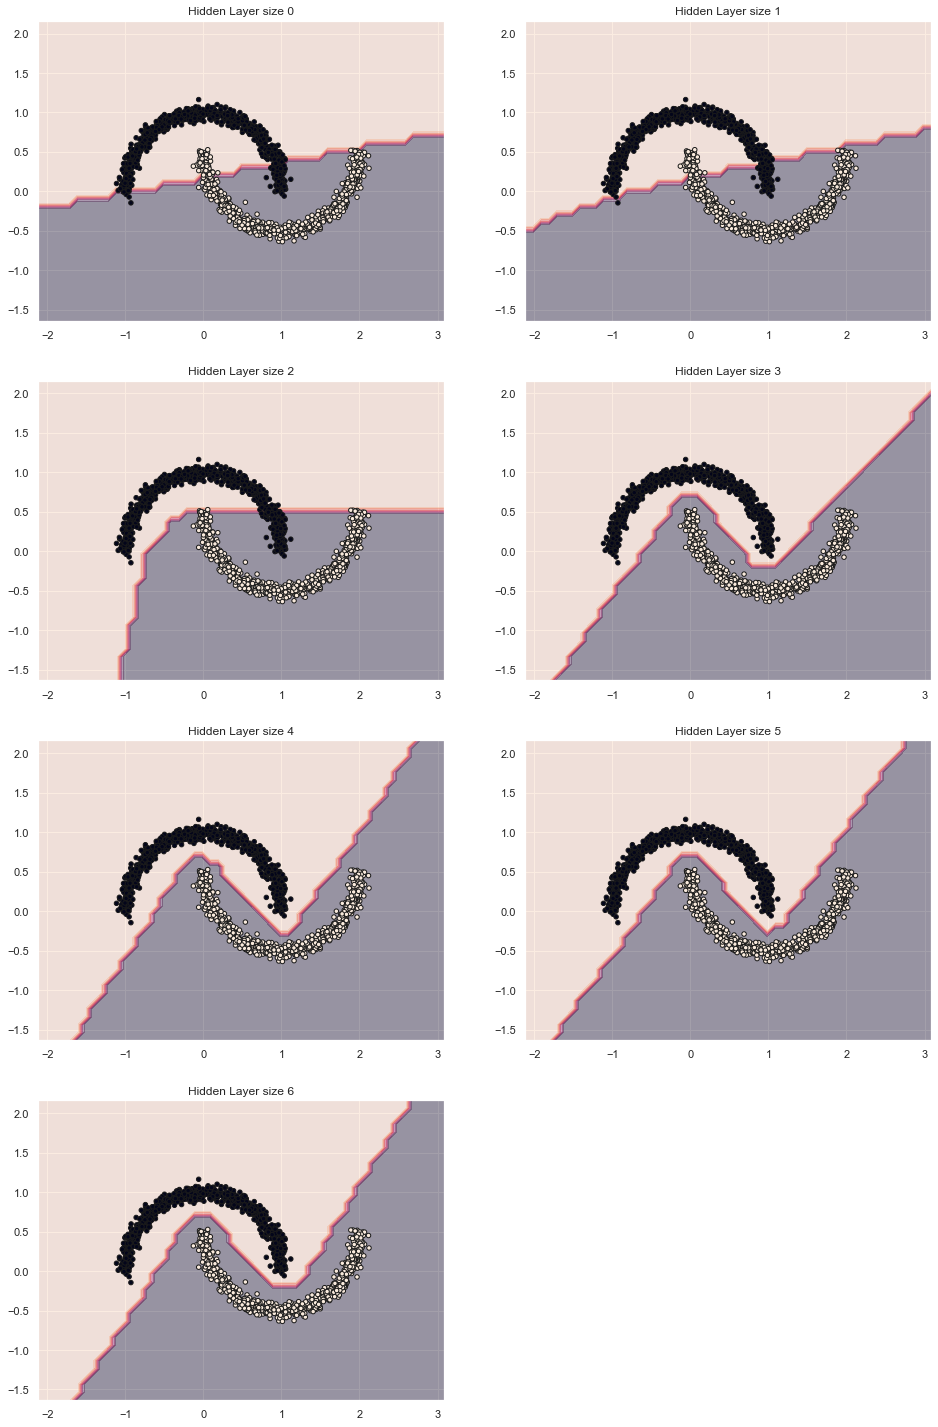

In [92]:
### Decision Boundaries MOON try
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i in range(len(hidden_layer_dimensions)):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % i)
    hiddenlayers = hidden_layer_dimensions[i]
    modelmoon = DNNClassifier(layer_dims=[X.shape[0], hiddenlayers, 2],hidden_layers=['sigmoid','softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=512,max_epoch=700,verbose=0,seed=25)
    modelmoon.fit(X,Y)
    
    znew = modelmoon.predict(np.c_[xx.ravel(), yy.ravel()].T)
    znew = znew.reshape(xx.shape)

    plt.contourf(xx, yy, znew,alpha=0.4)
    #plt.axis('off')
    plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.show()

In [143]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data = load_breast_cancer()

data.feature_names
Xbc = data.data[:,[0,1]].T
ybc = data.target
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Ybc = lb.fit_transform(ybc)
ybc_next = np.where(ybc==0,1,0)
Ybc = Ybc.T
Ybc = list(Ybc)
Ybc.append(ybc_next)
Ybc = np.array(Ybc)

In [144]:
print(Xbc.shape)
print(Ybc.shape)

(2, 569)
(2, 569)


In [145]:
model_bc = DNNClassifier(layer_dims=[Xbc.shape[0], 6, 4,3, 2],hidden_layers=[('relu',0),('relu',0.001),'sigmoid','softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=64,max_epoch=200,verbose=1,seed=25)
model_bc.fit(Xbc,Ybc)[1]

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.6626207992138711
Cost after iteration 200: 0.45154855163375895
Cost after iteration 300: 0.29238421823389926
Cost after iteration 400: 0.27294229226005684
Cost after iteration 500: 0.23810053891477473
Cost after iteration 600: 0.3662789442265992
Cost after iteration 700: 0.22932947273208476
Cost after iteration 800: 0.28771234737371526
Cost after iteration 900: 0.3263045317841088
Cost after iteration 1000: 0.28614026371789547
Cost after iteration 1100: 0.3652386758397088
Cost after iteration 1200: 0.23726812634830755
Cost after iteration 1300: 0.31325910995021344
Cost after iteration 1400: 0.2676144220538755
Cost after iteration 1500: 0.40516820620327776
Cost after iteration 1600: 0.332099054463057
Cost after iteration 1700: 0.3551572871915247
Cost after iteration 1800: 0.2231656903527655


0.2231656903527655

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.6626207992138711
Cost after iteration 200: 0.45154855163375895
Cost after iteration 300: 0.29238421823389926
Cost after iteration 400: 0.27294229226005684
Cost after iteration 500: 0.23810053891477473
Cost after iteration 600: 0.3662789442265992
Cost after iteration 700: 0.22932947273208476
Cost after iteration 800: 0.28771234737371526
Cost after iteration 900: 0.3263045317841088
Cost after iteration 1000: 0.28614026371789547
Cost after iteration 1100: 0.3652386758397088
Cost after iteration 1200: 0.23726812634830755
Cost after iteration 1300: 0.31325910995021344
Cost after iteration 1400: 0.2676144220538755
Cost after iteration 1500: 0.40516820620327776
Cost after iteration 1600: 0.332099054463057
Cost after iteration 1700: 0.3551572871915247
Cost after iteration 1800: 0.2231656903527655
0.2231656903527655


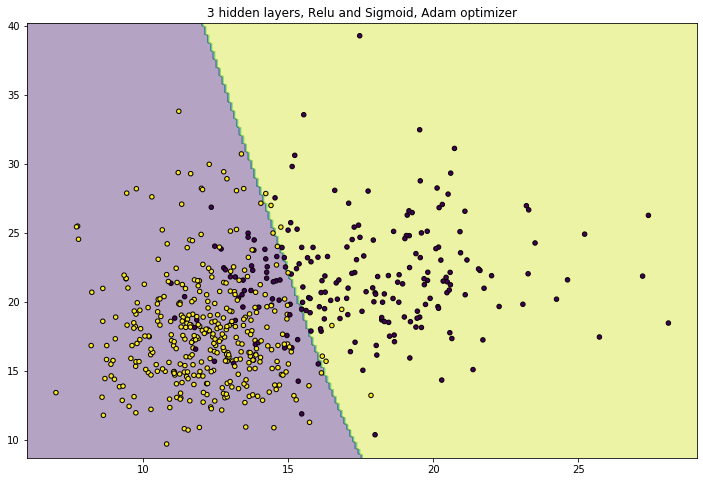

In [146]:
model_bc.predict(Xbc)

### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Zbc = model_bc.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Zbc = Zbc.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Zbc,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1],c=ybc, s=20, edgecolor='k')
plt.title('3 hidden layers, Relu and Sigmoid, Adam optimizer')
print(model_bc.fit(Xbc,Ybc)[1])

In [147]:
comparisons = model_bc.predict(Xbc) - Ybc[1]
count = 0
for i in comparisons:
    if i == 0:
        count += 1
accuracy = count / len(Ybc[1])
accuracy

0.8910369068541301

1
Initilizing Weights...
Starting Training...
Cost after iteration 100: 5.381103251587549
Cost after iteration 200: 3.34036343878231
Cost after iteration 300: 2.6872274550416115
Cost after iteration 400: 5.802181823497176
Cost after iteration 500: 0.8391080871819301
Cost after iteration 600: 4.035230843220979
Cost after iteration 700: 1.7499312120700958
Cost after iteration 800: 5.127086973265541
Cost after iteration 900: 0.7567229343983419
Cost after iteration 1000: 0.5592822954685515
Cost after iteration 1100: 3.1295613216853484
Cost after iteration 1200: 0.5948741471878696
Cost after iteration 1300: 1.266537915055667
Cost after iteration 1400: 0.850380457117411
Cost after iteration 1500: 0.9274255149379154
Cost after iteration 1600: 0.8129317496961133
Cost after iteration 1700: 0.6593335983630402
Cost after iteration 1800: 1.131822130759811
Cost after iteration 1900: 1.4589308794351195
Cost after iteration 2000: 0.6203387639780309
Cost after iteration 2100: 0.9106907402858072
Cost a

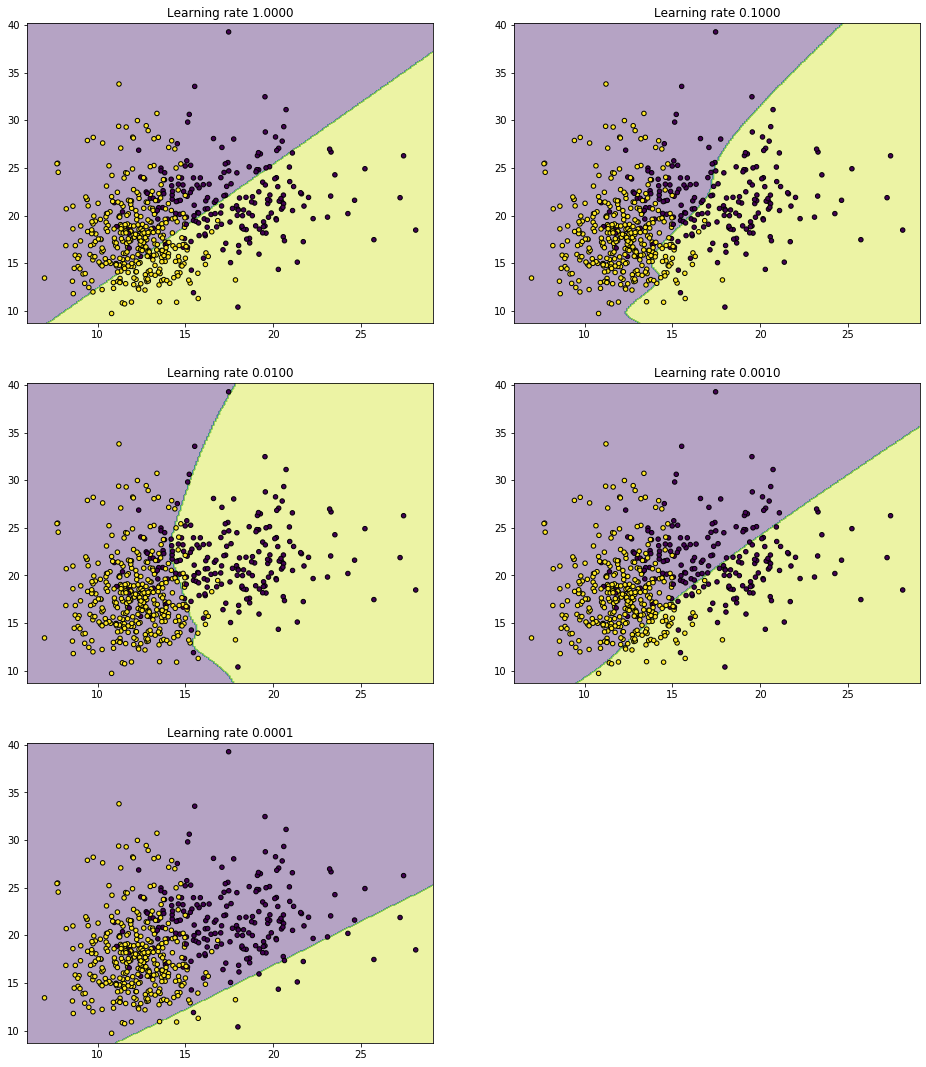

{1: 3.5490224791426828, 0.1: 0.5112974190498192, 0.01: 0.34094885641230416, 0.001: 0.5753078693337215, 0.0001: 0.6475025948209425}


In [11]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

dict_cost = {}

plt.figure(figsize=(16, 32))
learning_rates = [1, 0.1, 0.01, 0.001, 0.0001]
for i in range(len(learning_rates)):
    plt.subplot(5, 2, i+1)
    print(learning_rates[i])
    plt.title('Learning rate %1.4f' % learning_rates[i])
    hiddenlayers = hidden_layer_dimensions[i]
    modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=['sigmoid','softmax'],
                      optimization_method='SGDM',tolarance=None,batch_size=64,max_epoch=700,verbose=1,seed=25, 
                        learning_rate=learning_rates[i])
    modelbc.fit(Xbc,Ybc)
    
    dict_cost[learning_rates[i]] =  modelbc.fit(Xbc,Ybc)[1]
    
    znew = modelbc.predict(np.c_[xx.ravel(), yy.ravel()].T)
    znew = znew.reshape(xx.shape)

    plt.contourf(xx, yy, znew,alpha=0.4)
    #plt.axis('off')
    plt.scatter(dt[:, 0], dt[:, 1], c=ybc,s=20, edgecolor='k')
plt.show()
print(dict_cost)

#'f model: T=%i' %t

In [56]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

mse_matrix = np.zeros((450, 11))

learning_rates = [0.5, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.00001]


for i in range(len(learning_rates)):
        
        modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=['sigmoid','softmax'],
                          optimization_method='SGD',tolarance=None,batch_size=64,max_epoch=50,verbose=0,seed=25, 
                            learning_rate=learning_rates[i],penality='l2',lamda=0.001)
        mse_matrix[:,i] = modelbc.fit(Xbc,Ybc)[2]       

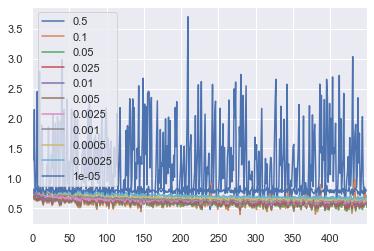

In [57]:
df = pd.DataFrame(mse_matrix)
pl = df.plot()
pl.legend(learning_rates)

In [58]:
dictionary = {}
learning_rates = [0.5, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.00001]

for col in range (len(learning_rates)):
    mse_min = min(mse_matrix[:,col])
    dictionary[learning_rates[col]] = mse_min
dictionary

{0.5: 0.47985398404050883,
 0.1: 0.39590370548213505,
 0.05: 0.45004057743084763,
 0.025: 0.47065495682531644,
 0.01: 0.49591679936368155,
 0.005: 0.516552513363693,
 0.0025: 0.5344189474261563,
 0.001: 0.5626061466133558,
 0.0005: 0.5945266623074643,
 0.00025: 0.6430337938729803,
 1e-05: 0.7000474383242763}

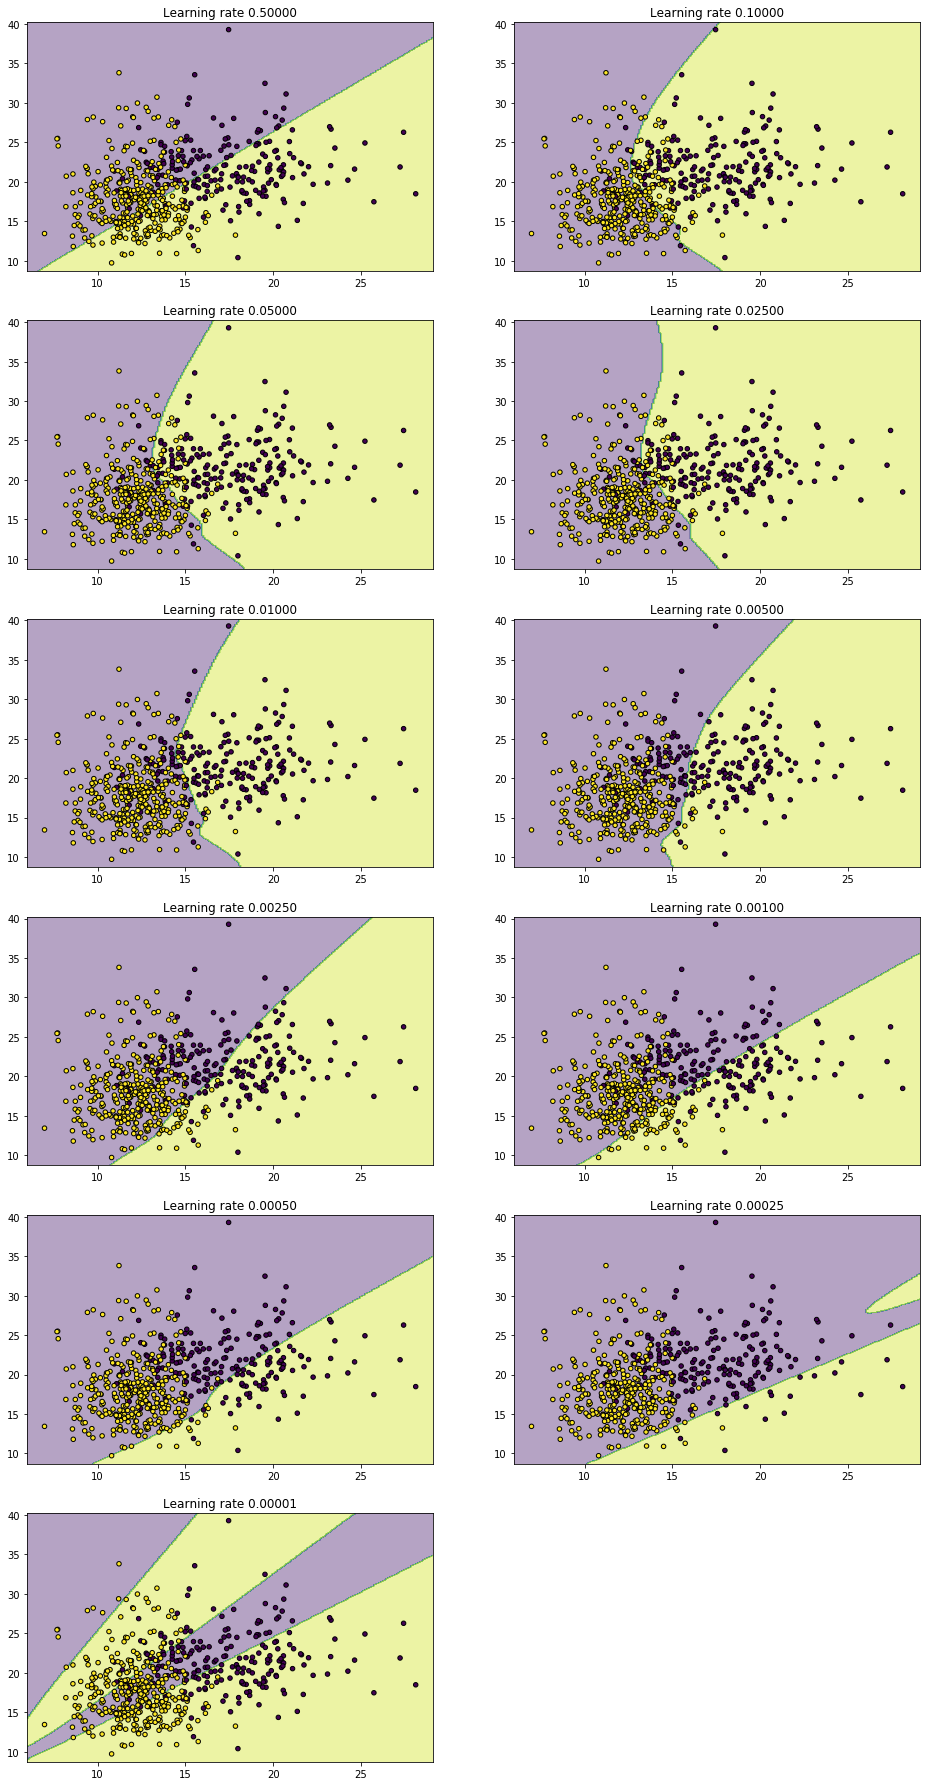

accuracies: {0.5: 0.6274165202108963, 0.1: 0.8681898066783831, 0.05: 0.9015817223198594, 0.025: 0.8998242530755711, 0.01: 0.8875219683655536, 0.005: 0.843585237258348, 0.0025: 0.7680140597539543, 0.001: 0.7012302284710018, 0.0005: 0.7293497363796133, 0.00025: 0.6449912126537786, 1e-05: 0.4868189806678383}


In [90]:
### Different learning rates
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

accuracies = {}

plt.figure(figsize=(16, 32))
learning_rates = [0.5, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.00001]
for i in range(len(learning_rates)):
    plt.subplot(6, 2, i+1)
    plt.title('Learning rate %1.5f' % learning_rates[i])
    modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=['sigmoid','softmax'],
                      optimization_method='SGDM',tolarance=None,batch_size=64,max_epoch=700,verbose=0,seed=25, 
                        learning_rate=learning_rates[i])
    modelbc.fit(Xbc,Ybc)
    
    comparisons = modelbc.predict(Xbc) - Ybc[1]
    count = 0
    for j in comparisons:
        if j == 0:
            count += 1
    accuracy = count / len(Ybc[1])
    accuracies[learning_rates[i]] = accuracy
    

    znew = modelbc.predict(np.c_[xx.ravel(), yy.ravel()].T)
    znew = znew.reshape(xx.shape)

    plt.contourf(xx, yy, znew,alpha=0.4)
    #plt.axis('off')
    plt.scatter(dt[:, 0], dt[:, 1], c=ybc,s=20, edgecolor='k')
plt.show()
print("accuracies: " + str(accuracies))
#'f model: T=%i' %t

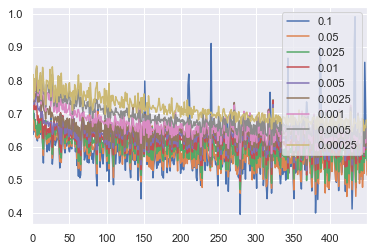

In [60]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

mse_matrix = np.zeros((450, 9))

learning_rates = [0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025]


for i in range(len(learning_rates)):
        
        modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=['sigmoid','softmax'],
                          optimization_method='SGD',tolarance=None,batch_size=64,max_epoch=50,verbose=0,seed=25, 
                            learning_rate=learning_rates[i],penality='l2',lamda=0.001)  
        mse_matrix[:,i] = modelbc.fit(Xbc,Ybc)[2]       
        
        
df = pd.DataFrame(mse_matrix)
pl = df.plot()
pl.legend(learning_rates)

<Figure size 1152x2304 with 0 Axes>

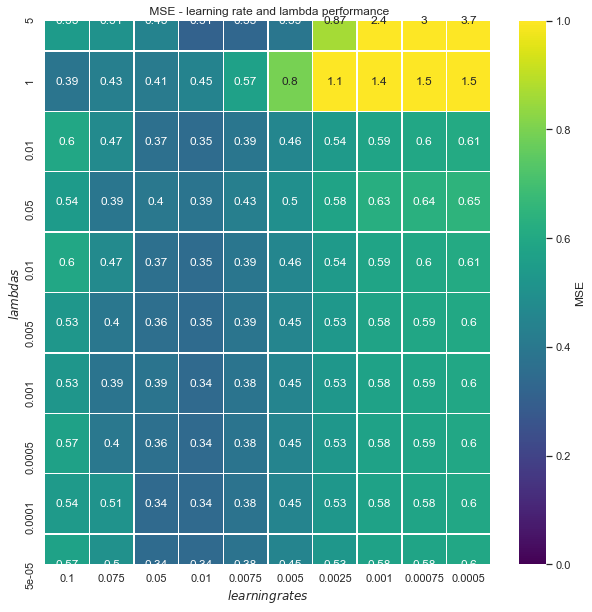

In [68]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

plt.figure(figsize=(16, 32))
learning_rates = [0.1, 0.075, 0.05, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075, 0.0005]
lambdas = [5, 1, 0.01, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]

mse_d = np.zeros((len(lambdas), len(learning_rates)))

for j in range(len(lambdas)):
    for i in range(len(learning_rates)):
        
        modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=['sigmoid','softmax'],
                          optimization_method='SGD',tolarance=None,batch_size=64,max_epoch=700,verbose=0,seed=25, 
                            learning_rate=learning_rates[i],penality='l2',lamda=lambdas[j])
        mse_d[j][i] = modelbc.fit(Xbc,Ybc)[1]

import seaborn as sns

sns.set()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(mse_d, annot=True, ax=ax, cmap="viridis", xticklabels=learning_rates, cbar_kws={'label': 'MSE'}, yticklabels=lambdas, vmin=0, vmax=1, linewidths=.5)
ax.set_title(" MSE - learning rate and lambda performance")
ax.set_ylabel("$lambdas$")
ax.set_xlabel("$learning rates$")
plt.show()

<Figure size 1152x2304 with 0 Axes>

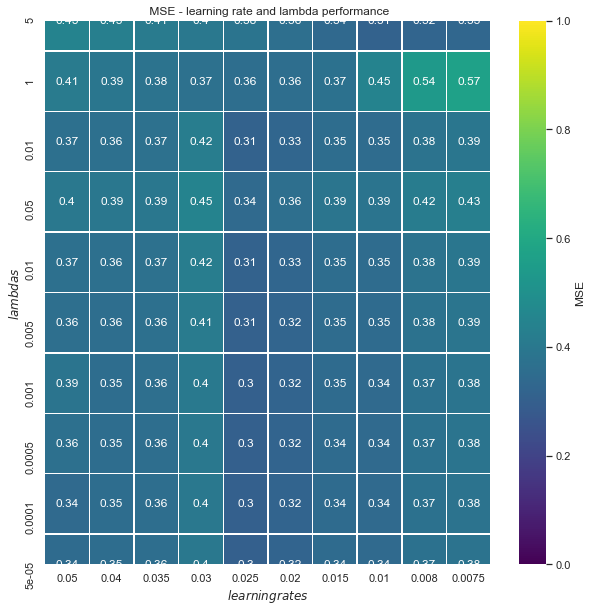

In [69]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

learning_rates = [0.05, 0.04, 0.035, 0.03, 0.025, 0.02,0.015, 0.01, 0.008, 0.0075]
lambdas = [5, 1, 0.01, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]

mse_d = np.zeros((len(lambdas), len(learning_rates)))

for j in range(len(lambdas)):
    for i in range(len(learning_rates)):
        
        modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=['sigmoid','softmax'],
                          optimization_method='SGD',tolarance=None,batch_size=64,max_epoch=700,verbose=0,seed=25, 
                            learning_rate=learning_rates[i],penality='l2',lamda=lambdas[j])
        mse_d[j][i] = modelbc.fit(Xbc,Ybc)[1]

import seaborn as sns

sns.set()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(mse_d, annot=True, ax=ax, cmap="viridis", xticklabels=learning_rates, cbar_kws={'label': 'MSE'}, yticklabels=lambdas, vmin=0, vmax=1, linewidths=.5)
ax.set_title(" MSE - learning rate and lambda performance")
ax.set_ylabel("$lambdas$")
ax.set_xlabel("$learning rates$")
plt.show()

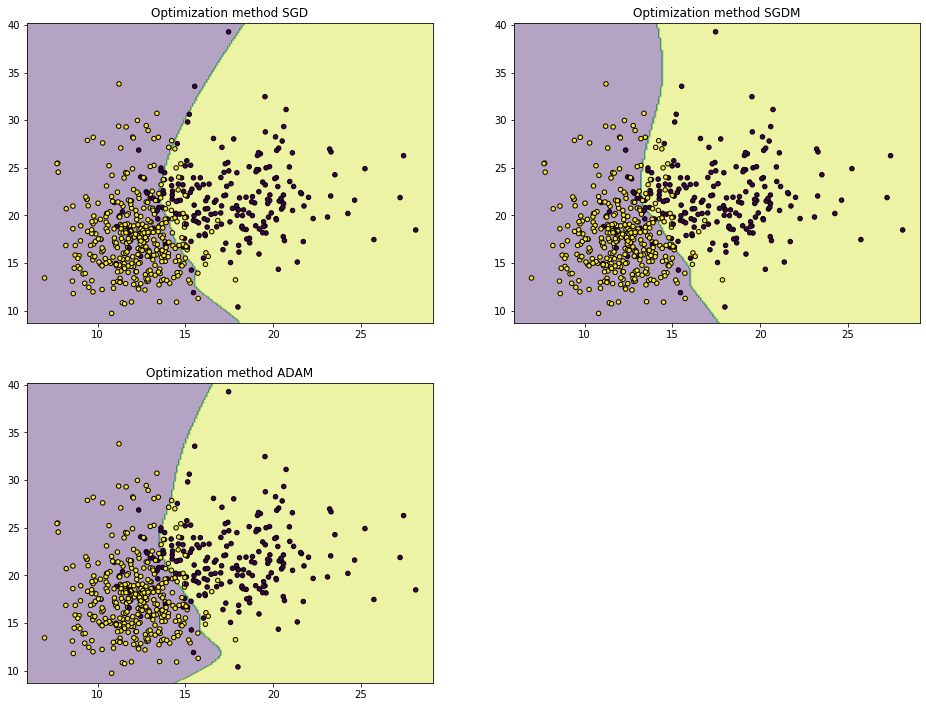

{'SGD': 0.3032021444097058, 'SGDM': 0.24731556306283467, 'ADAM': 0.2495660805281917}
accuracies: {'SGD': 0.8892794376098418, 'SGDM': 0.8998242530755711, 'ADAM': 0.9015817223198594}


In [93]:
### Different optimization methods
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


opt = ['SGD','SGDM','ADAM']
plt.figure(figsize=(16, 32))
dict_cost = {}
accuracies = {}

for i in range(len(opt)):
    plt.subplot(5, 2, i+1)
    plt.title('Optimization method ' + str(opt[i]))
    modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=['sigmoid','softmax'],
                      optimization_method=opt[i],tolarance=None,batch_size=64,max_epoch=700,verbose=0,seed=25,
                      learning_rate=0.025, penality='l2',lamda=0.001)
    modelbc.fit(Xbc,Ybc)
    dict_cost[opt[i]] = modelbc.fit(Xbc,Ybc)[1]
    znew = modelbc.predict(np.c_[xx.ravel(), yy.ravel()].T)
    znew = znew.reshape(xx.shape)
    
    comparisons = modelbc.predict(Xbc) - Ybc[1]
    count = 0
    for j in comparisons:
        if j == 0:
            count += 1
    accuracy = count / len(Ybc[1])
    accuracies[opt[i]] = accuracy

    plt.contourf(xx, yy, znew,alpha=0.4)
    #plt.axis('off')
    plt.scatter(dt[:, 0], dt[:, 1], c=ybc,s=20, edgecolor='k')
plt.show()
print(dict_cost)
print("accuracies: " + str(accuracies))

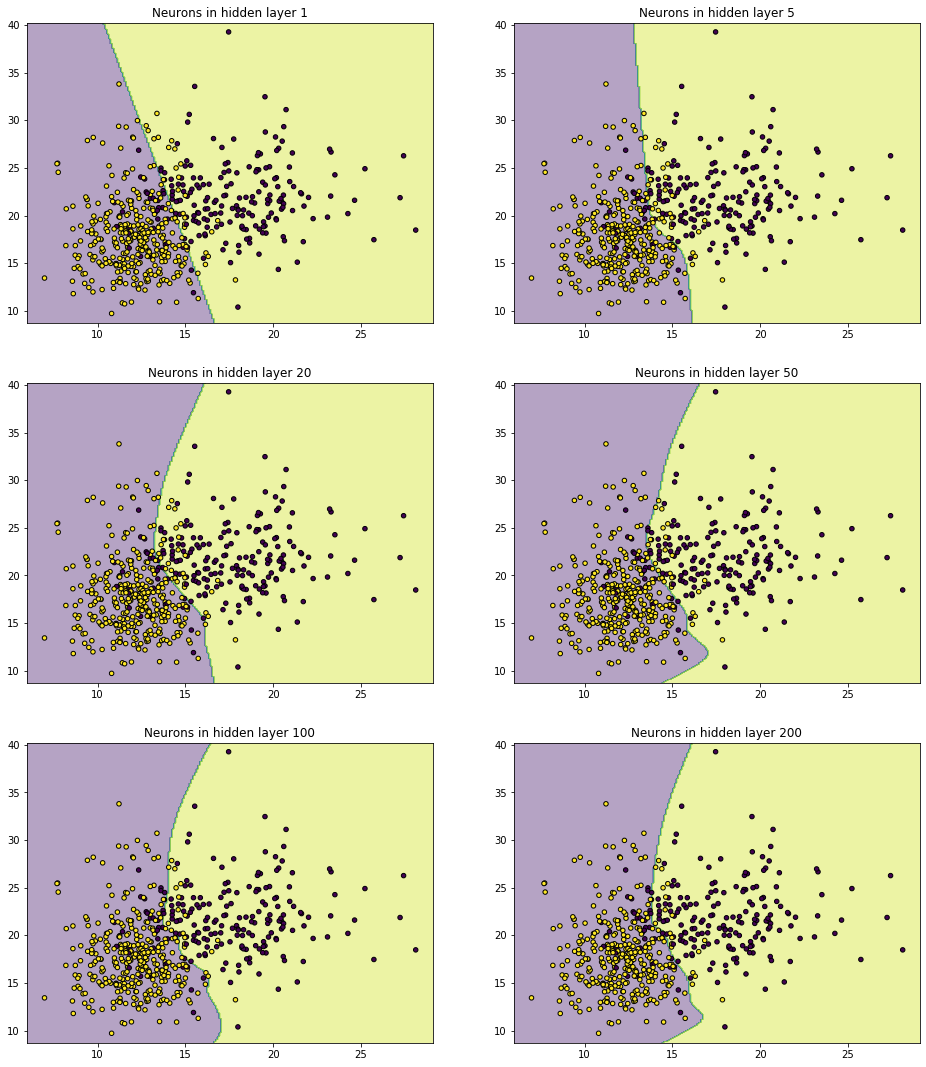

{1: 0.2156518554077919, 5: 0.3356828592881317, 20: 0.46716717866143, 50: 0.2495660805281917, 100: 0.2583382469846893, 200: 0.25125961178540024}
accuracies: {1: 0.8998242530755711, 5: 0.8998242530755711, 20: 0.8980667838312829, 50: 0.9015817223198594, 100: 0.8998242530755711, 200: 0.8980667838312829}


In [95]:
### Different number of neurons
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

dict_cost = {}
accuracies = {}

plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 5, 20, 50, 100, 200]
for i in range(len(hidden_layer_dimensions)):
    plt.subplot(5, 2, i+1)
    plt.title('Neurons in hidden layer %d' % hidden_layer_dimensions[i])
    hiddenlayers = hidden_layer_dimensions[i]
    modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], hiddenlayers, 2],hidden_layers=['sigmoid','softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=64,max_epoch=700,verbose=0,seed=25,
                      learning_rate=0.025, penality='l2',lamda=0.001)
    modelbc.fit(Xbc,Ybc)
    
    dict_cost[hidden_layer_dimensions[i]] =  modelbc.fit(Xbc,Ybc)[1]
    
    comparisons = modelbc.predict(Xbc) - Ybc[1]
    count = 0
    for j in comparisons:
        if j == 0:
            count += 1
    accuracy = count / len(Ybc[1])
    accuracies[hidden_layer_dimensions[i]] = accuracy
    
    znew = modelbc.predict(np.c_[xx.ravel(), yy.ravel()].T)
    znew = znew.reshape(xx.shape)

    plt.contourf(xx, yy, znew,alpha=0.4)
    #plt.axis('off')
    plt.scatter(dt[:, 0], dt[:, 1], c=ybc,s=20, edgecolor='k')
plt.show()
print(dict_cost)
print("accuracies: " + str(accuracies))

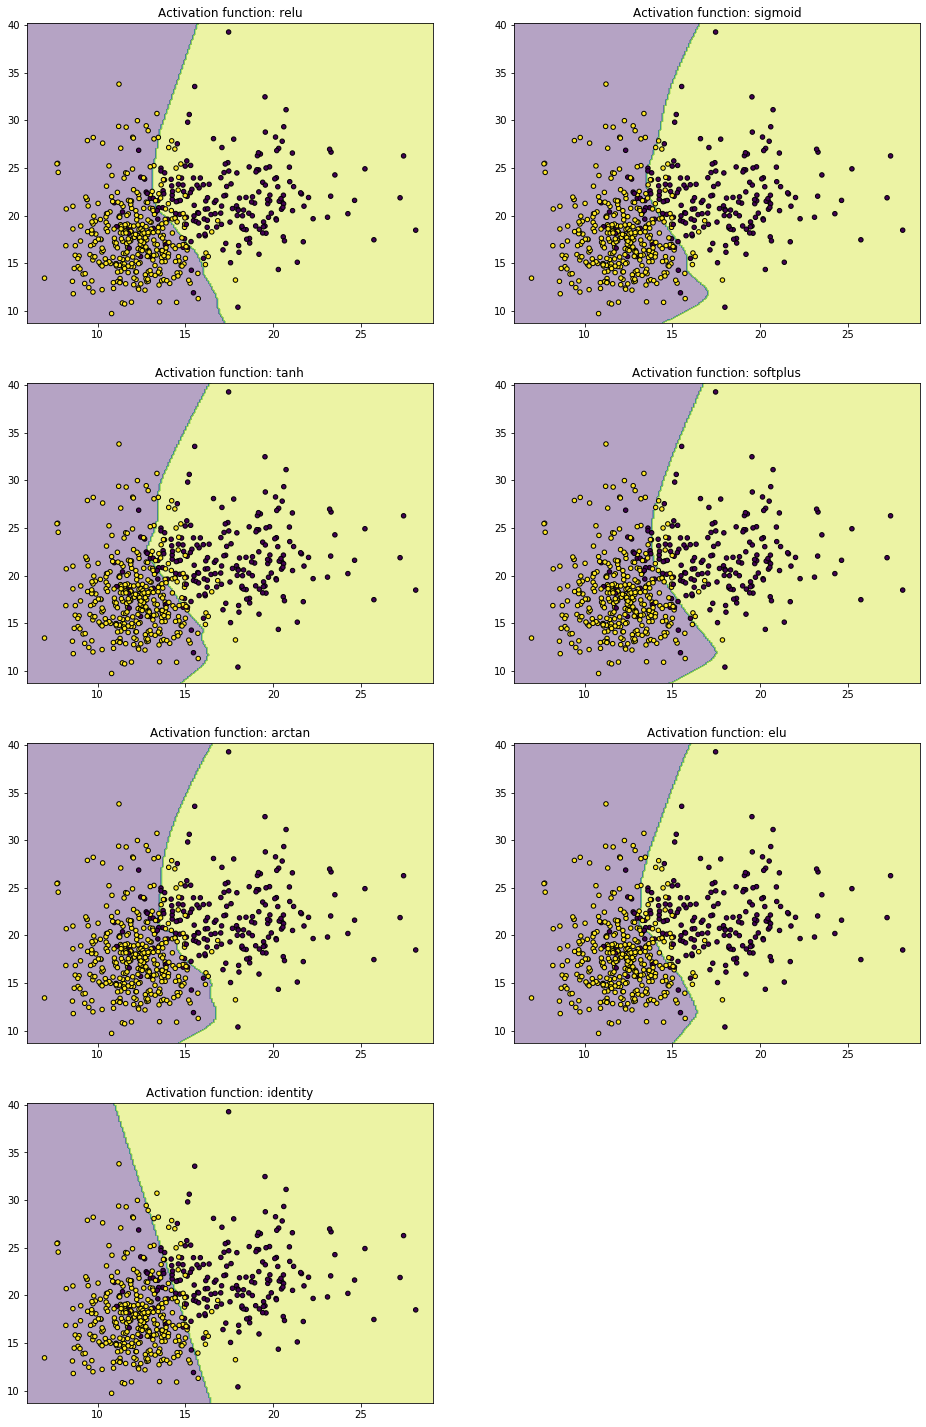

{'relu': 0.2314011595892161, 'sigmoid': 0.2495660805281917, 'tanh': 0.2516282001626333, 'softplus': 0.25259373465584684, 'arctan': 0.2405185857088995, 'elu': 0.23866464770071028, 'identity': 0.26018343634019625}
accuracies: {'relu': 0.8998242530755711, 'sigmoid': 0.9015817223198594, 'tanh': 0.8927943760984183, 'softplus': 0.9015817223198594, 'arctan': 0.9033391915641477, 'elu': 0.8998242530755711, 'identity': 0.8980667838312829}


In [96]:
'relu','sigmoid','tanh','softplus','arctan','elu','identity'

### Different number of neurons
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

dict_cost = {}
accuracies = {}

plt.figure(figsize=(16, 32))
act_function = ['relu','sigmoid','tanh','softplus','arctan','elu','identity']
for i in range(len(act_function)):
    plt.subplot(5, 2, i+1)
    plt.title('Activation function: ' + str(act_function[i]))
    
    #0.2 because alpha for the relu,elu,, is generally between 0.1 and 0.3
    
    if act_function[i] == 'relu':
        modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=[('relu', 0.2),'softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=64,max_epoch=700,verbose=0,seed=25,
                      learning_rate=0.025, penality='l2',lamda=0.001)
    elif act_function[i] == 'relu':
        modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=[('elu', 0.2),'softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=64,max_epoch=700,verbose=0,seed=25,
                      learning_rate=0.025, penality='l2',lamda=0.001)
    else:
        modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=[str(act_function[i]),'softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=64,max_epoch=700,verbose=0,seed=25,
                      learning_rate=0.025, penality='l2',lamda=0.001)
    modelbc.fit(Xbc,Ybc)
    
    dict_cost[act_function[i]] =  modelbc.fit(Xbc,Ybc)[1]
    comparisons = modelbc.predict(Xbc) - Ybc[1]
    count = 0
    for j in comparisons:
        if j == 0:
            count += 1
    accuracy = count / len(Ybc[1])
    accuracies[act_function[i]] = accuracy
    
    znew = modelbc.predict(np.c_[xx.ravel(), yy.ravel()].T)
    znew = znew.reshape(xx.shape)

    plt.contourf(xx, yy, znew,alpha=0.4)
    #plt.axis('off')
    plt.scatter(dt[:, 0], dt[:, 1], c=ybc,s=20, edgecolor='k')
plt.show()
print(dict_cost)
print("accuracies: " + str(accuracies))

Mse 0.24051859 
Accuracy 0.90333919 


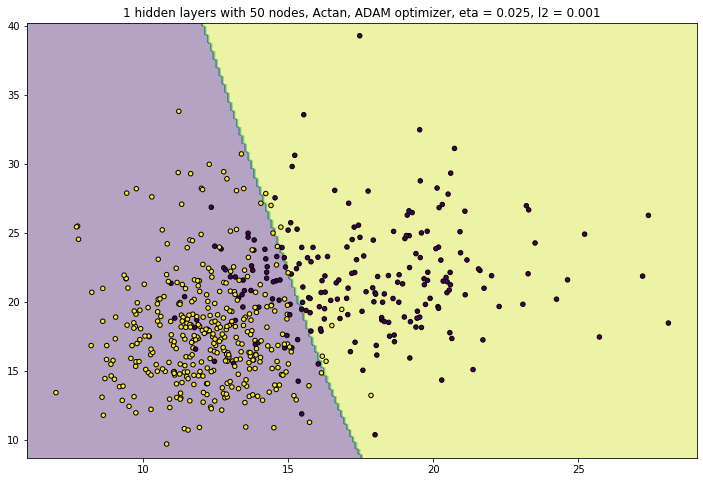

In [101]:
modelbc = DNNClassifier(layer_dims=[Xbc.shape[0], 50, 2],hidden_layers=['arctan','softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=64,max_epoch=700,verbose=0,seed=25,
                      learning_rate=0.025, penality='l2',lamda=0.001)
modelbc.fit(Xbc,Ybc)


%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,1]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Zbc = model_bc.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Zbc = Zbc.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Zbc,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1],c=ybc, s=20, edgecolor='k')
plt.title('1 hidden layers with 50 nodes, Actan, ADAM optimizer, eta = 0.025, l2 = 0.001')

comparisons = modelbc.predict(Xbc) - Ybc[1]
count = 0
for i in comparisons:
    if i == 0:
        count += 1
accuracy = count / len(Ybc[1])

print("Mse %1.8f " % modelbc.fit(Xbc,Ybc)[1])
print("Accuracy %1.8f " % accuracy)

In [148]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

data = load_breast_cancer()

data.feature_names
X = data.data[:,[0,1]]
Y = data.target

clf = LogisticRegression().fit(X, Y)
pre = clf.predict(X)

comparisons = pre - ybc
count = 0
for i in comparisons:
    if i == 0:
        count += 1
accuracy = count / (ybc.size)
print(accuracy)


0.8927943760984183
